In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import os
from IPython import display
import logging

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [3]:
# Required for Jupyter Notebook to find the graphviz executables
os.environ["PATH"] += os.pathsep + os.path.abspath("/opt/homebrew/bin/")

In [4]:
# Sample function for gradient calculation
def f(x):
    return 3*x**2 - 4*x + 5

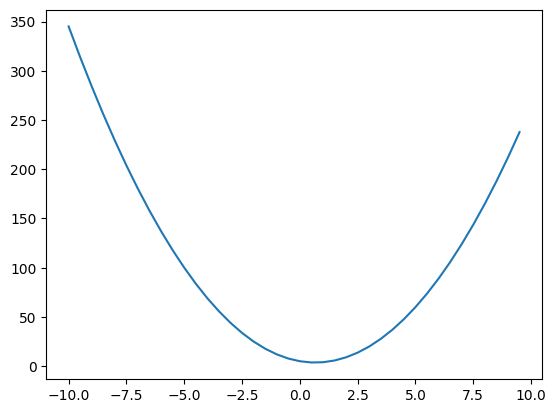

In [5]:
xs = np.arange(-10, 10, 0.5)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [6]:
h = 0.000001

In [7]:
a = 3
b = -2
c = 1
d1 = a*b + c

In [8]:
c = c + h
d2 = a*b + c

In [9]:
print("d1 = ", d1)
print("d2 = ", d2)
print("dc_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.999999
dc_dy =  1.000000000139778


In [10]:
a = 3; b = -2; c = 1
d1 = a*b + c
a = a + h
d2 = a*b + c
print("d1 = ", d1)
print("d2 = ", d2)
print("da_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -5.000002
da_dy =  -2.000000000279556


In [11]:
a = 3; b = -2; c = 1
d1 = a*b + c
b = b + h
d2 = a*b + c
print("d1 = ", d1)
print("d2 = ", d2)
print("db_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.9999970000000005
db_dy =  2.9999999995311555


In [12]:
a = 3; b = -2; c = 1
d1 = a*b + c
d2 = a*b + h + c
print("d1 = ", d1)
print("d2 = ", d2)
print("dab_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.999999
dab_dy =  1.000000000139778


In [13]:
class Value():
    """ Basic class to represent a scale value with arithmeti operations and gradients. """
    def __init__(self, data, _children=(), _op = '', grad=0.0, label=""):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0  # Gradient initialized to zero
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if isinstance(other, Value):
            return Value(self.data + other.data, _children=(self, other), _op='+')
        else:
            raise ValueError("Can only add Value to Value")
    
    def __mul__(self, other):
        if isinstance(other, Value):
            return Value(self.data * other.data, _children=(self, other), _op='*')
        else:
            raise ValueError("Can only multiply Value to Value")
        
    def tanh(self):
        return Value((np.exp(self.data*2) - 1)/(np.exp(self.data*2) + 1), _op='tanh', _children=(self,))

In [14]:
a = Value(3, label="a")
b = Value(-2, label="b")
c = Value(1, label="c")
d = a*b + c; d.label = "d"
print(f"d._prev = {d._prev} d = {d.data}")

d._prev = (Value(data=-6), Value(data=1)) d = -5


In [15]:
def draw_graph(root):
    """ Vibe codded and it works! """
    # Initialize a directed graph
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})  # Left-to-right layout
    
    def build_graph(node, visited=None):
        if visited is None:
            visited = set()
        
        # Skip if node already visited to avoid cycles
        if id(node) in visited:
            return
        visited.add(id(node))
        
        # Add node to the graph
        node_id = str(id(node))
        dot.node(node_id, f"{{ {node.label} | data = {node.data} grad={node.grad} }}", shape='record')
        
        # If node has an operation, create an operation node
        if node._op:
            op_id = f"{node_id}_op"
            dot.node(op_id, node._op, shape='circle')
            dot.edge(op_id, node_id)  # Edge from operation to result
        
            # Recursively process children
            for child in node._prev:
                child_id = str(id(child))
                build_graph(child, visited)
                dot.edge(child_id, op_id)  # Edge from child to operation
    
    # Build the graph starting from the root
    build_graph(root)
    
    # Render and display the graph
    dot.render('computation_graph', view=True, cleanup=True)
    
    return dot


In [16]:
# draw_graph(d)

In [17]:
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

x1 = Value(2, label="x1")
x2 = Value(3, label="x2")
w1 = Value(0.5, label="w1")
w2 = Value(-1.5, label="w2")
b = Value(1, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = "x1w1_x2w2"
y = x1w1_x2w2 + b; y.label = "y"
o = y.tanh(); o.label = "o"

In [18]:
print(f"o = {o.data}")

o = -0.9866142981514304


In [19]:
# draw_graph(o)

In [20]:
# Backpropagation
o.grad = 1.0  # Set the gradient of the output to 1.0

In [21]:
# draw_graph(o)

In [22]:
do_dn = 1 - math.tanh(o.data)**2
y.grad = do_dn

In [23]:
# draw_graph(o)

In [24]:
x1w1_x2w2.grad = y.grad
b.grad = y.grad
x1w1.grad = x1w1_x2w2.grad
x2w2.grad = x1w1_x2w2.grad

# draw_graph(o)

In [25]:
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

# draw_graph(o)

In [744]:
# Implement generic backpropagation
class Value():
    """ Complete class with backprop to represent a scale value with arithmeti operations and gradients. """
    visited = set()  # Set to keep track of visited nodes during backpropagation
    def __init__(self, data, _children=(), _op = '', grad=0.0, label=""):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0  # Gradient initialized to zero

    def backward(self):
        topo = []  # Topological order of nodes for backpropagation
        def build_topo(v, visited=None):
            if visited is None:
                visited = set()
            if id(v) not in visited:
                visited.add(id(v))
                for child in v._prev:
                    build_topo(child, visited)
                topo.append(v)
        build_topo(self)

        for item in reversed(topo):
            item._backward()
            
    def _backward(self):
        """ Perform backpropagation to compute gradients. """
        logger.debug(f"Backward pass for node: {self.label}, op: {self._op}, data: {self.data}, grad: {self.grad}")
        # For addition operation, local gradient is 1 for each child hence gradient of the child with respect
        # to the output is 1 * self gradient.
        # Note, we need to accumulate gradients for each child and not simply overwrite them.
        if self._op == '+':
            for child in self._prev:
                child.grad += self.grad

        # For multiplication operation, local gradient is the value of the other child hence
        # gradient of the child with respect to the output is self.grad * other child's value.
        elif self._op == '*':
            self._prev[0].grad += self.grad * self._prev[1].data
            self._prev[1].grad += self.grad * self._prev[0].data

        elif self._op == '/':
            # For division operation, local gradient is 1 / other child's value hence
            # gradient of the child with respect to the output is self.grad * (1 / other child's value).
            self._prev[0].grad += self.grad / self._prev[1].data
            self._prev[1].grad += -self.grad * (self._prev[0].data / (self._prev[1].data ** 2))

        # For power operation, local gradient is power * base^(power-1) hence
        # gradient of the child with respect to the output is self.grad * local gradient.
        elif self._op == '**':
            base = self._prev[0].data
            power = self._prev[1].data
            self._prev[0].grad += self.grad * power * (base ** (power - 1))

        # For subtraction operation, local gradient is 1 for the first child and -1 for the second child
        # hence gradient of the first child with respect to the output is self.grad * 1 and for the second child
        # it is self.grad * -1.
        elif self._op == '-':
            self._prev[0].grad += self.grad  # First child
            self._prev[1].grad += -self.grad  # Second child

        # For tanh operation, local gradient is 1 - tanh^2(self.data) hence
        # gradient of the child with respect to the output is self.grad * local gradient.
        elif self._op == 'tanh':
            logger.debug(f"tanh: self.data = {self.data}, self.grad = {self.grad}")
            self._prev[0].grad += self.grad * (1 - np.tanh(self._prev[0].data)**2)

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data + other.data, _children=(self, other), _op='+')

    def __radd__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data + other.data, _children=(self, other), _op='+')
    
    def __sub__(self, other):
        if isinstance(other, Value):
            return Value(self.data - other.data, _children=(self, other), _op='-')
        else:
            raise ValueError("Can only subtract Value from Value")
        
    def __mul__(self, other):
        if isinstance(other, Value):
            return Value(self.data * other.data, _children=(self, other), _op='*')
        else:
            raise ValueError("Can only multiply Value to Value")
        
    def __truediv__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data / other.data, _children=(self, other), _op='/')

    def __rtruediv__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data / other.data, _children=(self, other), _op='/')
        
    def __pow__(self, power):
        return Value(self.data ** power, _children=(self,Value(power)), _op='**')
        
    def tanh(self):
        return Value((np.exp(self.data*2) - 1)/(np.exp(self.data*2) + 1), _op='tanh', _children=(self,))

In [745]:
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

x1 = Value(2, label="x1")
x2 = Value(3, label="x2")
w1 = Value(0.5, label="w1")
w2 = Value(-1.5, label="w2")
b = Value(1, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = "x1w1_x2w2"
y = x1w1_x2w2 + b; y.label = "y"
o = y.tanh(); o.label = "o"

In [746]:
# draw_graph(o)

In [747]:
# Perform backpropagation
o.grad = 1.0  # Set the gradient of the output to 1.0

o.visited = set()  # Reset visited set for each backward pass
o.backward()

In [748]:
# draw_graph(o)

In [749]:
# Verfiy with PyTorch
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

import torch

x1 = torch.Tensor([2.0])
x2 = torch.Tensor([3.0])
w1 = torch.Tensor([0.5])
w2 = torch.Tensor([-1.5])
b = torch.Tensor([1.0])
x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

y = x1 * w1 + x2 * w2 + b
o = torch.tanh(y)

print(f"o = {o.item()}")

o.backward()  # Perform backpropagation

o = -0.9866142868995667


In [750]:
print(f"x1.grad = {x1.grad.item()}") 
print(f"x2.grad = {x2.grad.item()}") 
print(f"w1.grad = {w1.grad.item()}")
print(f"w2.grad = {w2.grad.item()}")
print(f"b.grad = {b.grad.item()}")

x1.grad = 0.013296124525368214
x2.grad = -0.039888374507427216
w1.grad = 0.053184498101472855
w2.grad = 0.07977674901485443
b.grad = 0.026592249050736427


In [751]:
import random
random.seed(42)  # For reproducibility

class N():
    """ Class to represent a single neuron with forward and backward pass. """
    def __init__(self, input_size, label=""):
        self.input_size = input_size
        self.weights = [Value(random.uniform(-1, 1), label = f"{label} w{i}") for i in range(input_size)]
        self.b = Value(random.uniform(-1, 1), label=f"{label} b")  # Bias term
    
    def parameters(self):
        return self.weights + [self.b]  # Return all parameters (weights and bias)
    
    def zero_grad(self):
        """ Reset gradients of all parameters to zero. """
        for param in self.parameters():
            param.grad = 0.0
            
    def __call__(self, input, act_fn=None) -> Value:
        """ Forward pass for the neuron. """
        assert len(input) == self.input_size, f"Input size {len(input)} does not match expected size {self.input_size}"
        wx = [w*x for w, x in zip(self.weights, input)]
        wx_sum = Value(0.0)  # Initialize sum of weighted inputs
        for item in wx:
            wx_sum += item  # Sum the weighted inputs

        wx_sum = wx_sum + self.b
        if act_fn is None:
            return wx_sum
        elif act_fn == 'tanh':
            return wx_sum.tanh()
        else:
            raise ValueError(f"Unsupported activation function: {act_fn}")

In [752]:
n = N(2)  # Create a neuron with 2 inputs
x1 = Value(2, label="x1")
x2 = Value(3, label="x2")

o = n([x1, x2])
print(f"o = {o.data}")

o = -2.742169638094225


In [753]:
class Layer():
    """ Class to represent a layer of neurons. """
    def __init__(self, input, output, label=""):
        self.input = input
        self.output = output
        self.neurons = [N(input, label=f"{label} Neuron {i}") for i in range(output)]
    
    def parameters(self):
        parameters = []
        for n in self.neurons:
            parameters.extend(n.parameters())  # Collect parameters from each neuron
        return parameters
            
    def zero_grad(self):
        """ Reset gradients of all parameters to zero. """
        for param in self.parameters():
            param.grad = 0.0
            
    def __call__(self, input, act_fn=None):
        """ Forward pass for the layer. """
        outputs = [n(input, act_fn) for n in self.neurons]
        return outputs

In [754]:
from typing import Callable

class NN():
    """ Class to represent a simple neural network with hidden layers. """
    def __init__(self, input_size: int, 
                 hidden_layer_num: int, 
                 hidden_layer_size: int, 
                 output_size: int):
        self.input_size = input_size
        self.hidden_layer_num = hidden_layer_num
        self.output_size = output_size
        self.hidden_layer_size = hidden_layer_size
        self.forward_hook = None  # Hook for forward pass

        self.layers = []
        for i in range(hidden_layer_num):
            if i == 0:
                # First layer takes the input size
                self.layers.append(Layer(input_size, hidden_layer_size, label=f"Layer {i}"))
            elif i == hidden_layer_num - 1:
                # Last layer is the output layer, use output_size
                self.layers.append(Layer(hidden_layer_size, output_size, label=f"Layer {i}"))
            else:
                # Intermediate layers use hidden_layer_size
                self.layers.append(Layer(hidden_layer_size, hidden_layer_size, label=f"Layer {i}"))
           
    def parameters(self):
        parameters = []
        for layer in self.layers:
            parameters.extend(layer.parameters())  # Collect parameters from each layer
        return parameters

    def zero_grad(self):
        """ Reset gradients of all parameters to zero. """
        for param in self.parameters():
            param.grad = 0.0
            
    def register_forward_hook(self, func: Callable[[str, list[Value], list[Value]], None]): 
        self.forward_hook = func

    def __call__(self, input):
        """ Forward pass for the neural network. """
        assert len(input) == self.input_size, "input size mismatch"

        x = [Value(i) for i in input]
        for num, layer in enumerate(self.layers):
            if num != len(self.layers) - 1:
                act_fn = 'tanh'
            else:
                act_fn = None
            input = x.copy()
            x = layer(x, act_fn)  # Forward pass through the layer
            self.forward_hook(f"Layer {num}", [i.data for i in input], [o.data for o in x]) if self.forward_hook else None

        return x

In [755]:
random.seed(42)  # For reproducibility
mlp = NN(input_size=3, hidden_layer_num=3, hidden_layer_size=4, output_size=1)  # Create a neural network with 2 inputs, 2 hidden layers of size 3, and 1 output 

In [756]:
print("model information:")
print(f"input size: {mlp.input_size}")
print(f"total model layers: {len(mlp.layers)}")
for i, layer in enumerate(mlp.layers):
    print(f"[{i}] layer input: {layer.input}, layer output: {layer.output}, neurons: {len(layer.neurons)}")
print(f"total model parameters: {len(mlp.parameters())}")

# Build tensor parameters for the model, this will be used to set the parameters in PyTorch
mlp_tensor_parameters = []
print("model parameters:")

# Save pre-defined parameters in a list of tensors
for layer_num, layer in enumerate(mlp.layers):
    layer_params = []
    bias_params = []
    for neuron_num, neuron in enumerate(layer.neurons):
        layer_params.append([x.data for x in neuron.parameters()][:-1])
        bias_params.append([x.data for x in neuron.parameters()][-1])
    mlp_tensor_parameters.append(torch.tensor(layer_params))
    mlp_tensor_parameters.append(torch.tensor(bias_params))
    
print(mlp_tensor_parameters)

model information:
input size: 3
total model layers: 3
[0] layer input: 3, layer output: 4, neurons: 4
[1] layer input: 4, layer output: 4, neurons: 4
[2] layer input: 4, layer output: 1, neurons: 1
total model parameters: 41
model parameters:
[tensor([[ 0.2789, -0.9500, -0.4499],
        [ 0.4729,  0.3534,  0.7844],
        [-0.1562, -0.9404, -0.5627],
        [-0.9469, -0.6023,  0.2998]]), tensor([-0.5536, -0.8261,  0.0107,  0.0899]), tensor([[-0.5591,  0.1785,  0.6189, -0.9870],
        [ 0.3963, -0.3195, -0.6890,  0.9144],
        [-0.8145, -0.8066,  0.6950,  0.2075],
        [ 0.4595,  0.0725,  0.9462, -0.2429]]), tensor([ 0.6116, -0.3268,  0.6143,  0.1041]), tensor([[0.6588, 0.2370, 0.7234, 0.1547]]), tensor([0.4091])]


In [757]:
# Create a PyTorch model with the same architecture for verification
import torch.nn as nn
torch.manual_seed(42)  # For reproducibility

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 4),  # First hidden layer
            nn.Tanh(),
            nn.Linear(4, 4),  # Second hidden layer
            nn.Tanh(),
            nn.Linear(4, 1)   # Output layer
        )
    def forward(self, x):
        return self.layers(x)

def hook_fn(module, input, output, name=None):
    """ Hook function to capture the output of each layer. """
    print(f"Layer: {module}, Input: {input}, Output: {output}")

def rmse(y_true, y_pred):
    """ Calculate Root Mean Squared Error. """
    diffs = torch.stack([(y_true_i - y_pred_i) ** 2 for y_true_i, y_pred_i in zip(y_true, y_pred)])
    return torch.mean(diffs)
    

In [758]:
tmlp = MLP(input_size=3)  # Create a PyTorch model with the same architecture
torch.manual_seed(42)  # For reproducibility

# Initialize the parameters of the PyTorch model with the values from our model
with torch.no_grad():
    for param_tmlp, param_mlp in zip(tmlp.parameters(), mlp_tensor_parameters):
        param_tmlp.copy_(param_mlp)

# Register hooks to capture the output of each layer
for name, module in tmlp.named_modules():
    print(f"Registering hook for layer: {name}")
    module.register_forward_hook(hook_fn)

print(f"model parameters = {[p for p in tmlp.parameters()]}")

Registering hook for layer: 
Registering hook for layer: layers
Registering hook for layer: layers.0
Registering hook for layer: layers.1
Registering hook for layer: layers.2
Registering hook for layer: layers.3
Registering hook for layer: layers.4
model parameters = [Parameter containing:
tensor([[ 0.2789, -0.9500, -0.4499],
        [ 0.4729,  0.3534,  0.7844],
        [-0.1562, -0.9404, -0.5627],
        [-0.9469, -0.6023,  0.2998]], requires_grad=True), Parameter containing:
tensor([-0.5536, -0.8261,  0.0107,  0.0899], requires_grad=True), Parameter containing:
tensor([[-0.5591,  0.1785,  0.6189, -0.9870],
        [ 0.3963, -0.3195, -0.6890,  0.9144],
        [-0.8145, -0.8066,  0.6950,  0.2075],
        [ 0.4595,  0.0725,  0.9462, -0.2429]], requires_grad=True), Parameter containing:
tensor([ 0.6116, -0.3268,  0.6143,  0.1041], requires_grad=True), Parameter containing:
tensor([[0.6588, 0.2370, 0.7234, 0.1547]], requires_grad=True), Parameter containing:
tensor([0.4091], requires_g

In [759]:
# Print parameters of the PyTorch model
print("PyTorch model parameters:")
for name, param in tmlp.named_parameters():
    print(f"{name}: data: {param.data} grad={param.grad}")

PyTorch model parameters:
layers.0.weight: data: tensor([[ 0.2789, -0.9500, -0.4499],
        [ 0.4729,  0.3534,  0.7844],
        [-0.1562, -0.9404, -0.5627],
        [-0.9469, -0.6023,  0.2998]]) grad=None
layers.0.bias: data: tensor([-0.5536, -0.8261,  0.0107,  0.0899]) grad=None
layers.2.weight: data: tensor([[-0.5591,  0.1785,  0.6189, -0.9870],
        [ 0.3963, -0.3195, -0.6890,  0.9144],
        [-0.8145, -0.8066,  0.6950,  0.2075],
        [ 0.4595,  0.0725,  0.9462, -0.2429]]) grad=None
layers.2.bias: data: tensor([ 0.6116, -0.3268,  0.6143,  0.1041]) grad=None
layers.4.weight: data: tensor([[0.6588, 0.2370, 0.7234, 0.1547]]) grad=None
layers.4.bias: data: tensor([0.4091]) grad=None


In [760]:
x = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

y = [1.0, -1.0, -1.0, 1.0]  # Example labels

In [761]:
def loss_fn_mse(y_preds, y_true):
    """Mean squared error loss function."""
    loss = sum([(i - j)**2 for i, j in zip(y_true, y_preds)])

    return loss/len(y_preds)

In [762]:
def loss_fn_mae(y_preds, y_true):
    """Mean absolute error loss function."""
    loss = sum([(i - j) for i, j in zip(y_preds, y_true)])

    return loss / len(y_preds)

In [763]:
# Print grads for our model
for param in mlp.parameters():
    print(f"param: {param.label}, data: {param.data}, grad: {param.grad}")

param: Layer 0 Neuron 0 w0, data: 0.2788535969157675, grad: 0.0
param: Layer 0 Neuron 0 w1, data: -0.9499784895546661, grad: 0.0
param: Layer 0 Neuron 0 w2, data: -0.4499413632617615, grad: 0.0
param: Layer 0 Neuron 0 b, data: -0.5535785237023545, grad: 0.0
param: Layer 0 Neuron 1 w0, data: 0.4729424283280248, grad: 0.0
param: Layer 0 Neuron 1 w1, data: 0.3533989748458226, grad: 0.0
param: Layer 0 Neuron 1 w2, data: 0.7843591354096908, grad: 0.0
param: Layer 0 Neuron 1 b, data: -0.8261223347411677, grad: 0.0
param: Layer 0 Neuron 2 w0, data: -0.15615636062945915, grad: 0.0
param: Layer 0 Neuron 2 w1, data: -0.9404055611238593, grad: 0.0
param: Layer 0 Neuron 2 w2, data: -0.5627240503927933, grad: 0.0
param: Layer 0 Neuron 2 b, data: 0.010710576206724776, grad: 0.0
param: Layer 0 Neuron 3 w0, data: -0.9469280606322728, grad: 0.0
param: Layer 0 Neuron 3 w1, data: -0.602324698626703, grad: 0.0
param: Layer 0 Neuron 3 w2, data: 0.2997688755590464, grad: 0.0
param: Layer 0 Neuron 3 b, data:

In [764]:
# First forward pass with our model
mlp.register_forward_hook(hook_fn)  # Register the hook to capture outputs
y_preds = mlp(x[0])
print(f"y_preds = {y_preds[0].data}")
print(f"y = {y[0]}")
loss = loss_fn_mse([y_preds[0]], [Value(y[0])])
print(f"loss = {loss}")

Layer: Layer 0, Input: [2.0, 3.0, -1.0], Output: [-0.983540418876898, 0.3761781385427304, -0.9881211941388645, -0.9991982278148795]
Layer: Layer 1, Input: [-0.983540418876898, 0.3761781385427304, -0.9881211941388645, -0.9991982278148795], Output: [0.9221810704816664, -0.7893076871461533, 0.2145409768394499, -0.7669251605843824]
Layer: Layer 2, Input: [0.9221810704816664, -0.7893076871461533, 0.2145409768394499, -0.7669251605843824], Output: [0.8661433515946025]
y_preds = 0.8661433515946025
y = 1.0
loss = Value(data=0.017917602322326195)


In [765]:
# draw_graph(loss)

In [766]:
# First forward pass with PyTorch model
y_preds_tmlp = tmlp(torch.tensor(x[0]))
print(f"y_preds_tmlp = {y_preds_tmlp.item()}")
loss_tmlp = loss_fn_mse([Value(y_preds_tmlp.item())], [Value(y[0])])
print(f"loss_tmlp = {loss_tmlp}")

Layer: Linear(in_features=3, out_features=4, bias=True), Input: (tensor([ 2.,  3., -1.]),), Output: tensor([-2.3959,  0.3956, -2.5601, -3.9107], grad_fn=<ViewBackward0>)
Layer: Tanh(), Input: (tensor([-2.3959,  0.3956, -2.5601, -3.9107], grad_fn=<ViewBackward0>),), Output: tensor([-0.9835,  0.3762, -0.9881, -0.9992], grad_fn=<TanhBackward0>)
Layer: Linear(in_features=4, out_features=4, bias=True), Input: (tensor([-0.9835,  0.3762, -0.9881, -0.9992], grad_fn=<TanhBackward0>),), Output: tensor([ 1.6034, -1.0696,  0.2179, -1.0128], grad_fn=<ViewBackward0>)
Layer: Tanh(), Input: (tensor([ 1.6034, -1.0696,  0.2179, -1.0128], grad_fn=<ViewBackward0>),), Output: tensor([ 0.9222, -0.7893,  0.2145, -0.7669], grad_fn=<TanhBackward0>)
Layer: Linear(in_features=4, out_features=1, bias=True), Input: (tensor([ 0.9222, -0.7893,  0.2145, -0.7669], grad_fn=<TanhBackward0>),), Output: tensor([0.8661], grad_fn=<ViewBackward0>)
Layer: Sequential(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (

In [767]:
# Backward pass with our model
mlp.zero_grad()
loss.grad = 1.0  # Set the gradient of the loss to 1.0
loss.visited = set()  # Reset visited set for each backward pass
loss.backward()

In [768]:
# Update parameters with gradients for our model
learning_rate = 0.001
for param in mlp.parameters():
    param.data -= learning_rate * param.grad

In [769]:
# Backward pass with PyTorch model
import torch.optim as optim

optimizer = optim.SGD(tmlp.parameters(), lr=learning_rate)  # Create an optimizer
tmlp.train()
optimizer.zero_grad()
output = tmlp(torch.tensor(x[0]))  # Forward pass
print(f"output = {output}")
loss_rmse = rmse([torch.tensor([y[0]])], [output])  # Calculate loss
loss_rmse.backward()  # Perform backpropagation

Layer: Linear(in_features=3, out_features=4, bias=True), Input: (tensor([ 2.,  3., -1.]),), Output: tensor([-2.3959,  0.3956, -2.5601, -3.9107], grad_fn=<ViewBackward0>)
Layer: Tanh(), Input: (tensor([-2.3959,  0.3956, -2.5601, -3.9107], grad_fn=<ViewBackward0>),), Output: tensor([-0.9835,  0.3762, -0.9881, -0.9992], grad_fn=<TanhBackward0>)
Layer: Linear(in_features=4, out_features=4, bias=True), Input: (tensor([-0.9835,  0.3762, -0.9881, -0.9992], grad_fn=<TanhBackward0>),), Output: tensor([ 1.6034, -1.0696,  0.2179, -1.0128], grad_fn=<ViewBackward0>)
Layer: Tanh(), Input: (tensor([ 1.6034, -1.0696,  0.2179, -1.0128], grad_fn=<ViewBackward0>),), Output: tensor([ 0.9222, -0.7893,  0.2145, -0.7669], grad_fn=<TanhBackward0>)
Layer: Linear(in_features=4, out_features=1, bias=True), Input: (tensor([ 0.9222, -0.7893,  0.2145, -0.7669], grad_fn=<TanhBackward0>),), Output: tensor([0.8661], grad_fn=<ViewBackward0>)
Layer: Sequential(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (

In [770]:
# Print gradients of the loss function
print(f"tmlp loss grad = {loss_rmse}")

tmlp loss grad = 0.017917603254318237


In [771]:
# Update parameters with gradients for PyTorch model
optimizer.step()  # Update parameters

In [773]:
# Print updated parameters for out model
print("Updated parameters for our model:")
for param in mlp.parameters():
    print(f"{param.label}: {param.data} (grad: {param.grad})")

Updated parameters for our model:
Layer 0 Neuron 0 w0: 0.2788439384702872 (grad: 0.009658445480288656)
Layer 0 Neuron 0 w1: -0.9499929772228866 (grad: 0.014487668220432983)
Layer 0 Neuron 0 w2: -0.44993653403902134 (grad: -0.004829222740144328)
Layer 0 Neuron 0 b: -0.5535833529250946 (grad: 0.004829222740144328)
Layer 0 Neuron 1 w0: 0.47268365591740313 (grad: 0.2587724106216494)
Layer 0 Neuron 1 w1: 0.3530108162298901 (grad: 0.38815861593247414)
Layer 0 Neuron 1 w2: 0.7844885216150016 (grad: -0.1293862053108247)
Layer 0 Neuron 1 b: -0.8262517209464785 (grad: 0.1293862053108247)
Layer 0 Neuron 2 w0: -0.156149540968433 (grad: -0.006819661026130761)
Layer 0 Neuron 2 w1: -0.9403953316323201 (grad: -0.010229491539196141)
Layer 0 Neuron 2 w2: -0.5627274602233063 (grad: 0.0034098305130653805)
Layer 0 Neuron 2 b: 0.010713986037237841 (grad: -0.0034098305130653805)
Layer 0 Neuron 3 w0: -0.9469279643907854 (grad: -9.624148732860756e-05)
Layer 0 Neuron 3 w1: -0.6023245542644721 (grad: -0.00014436

In [774]:
# Print updated parameters of PyTorch model
print("Updated parameters for PyTorch model:")
for name, param in tmlp.named_parameters():
    print(f"{name}: {param.data} (grad: {param.grad})")

Updated parameters for PyTorch model:
layers.0.weight: tensor([[ 0.2788, -0.9500, -0.4499],
        [ 0.4727,  0.3530,  0.7845],
        [-0.1561, -0.9404, -0.5627],
        [-0.9469, -0.6023,  0.2998]]) (grad: tensor([[ 9.6584e-03,  1.4488e-02, -4.8292e-03],
        [ 2.5877e-01,  3.8816e-01, -1.2939e-01],
        [-6.8197e-03, -1.0229e-02,  3.4098e-03],
        [-9.6238e-05, -1.4436e-04,  4.8119e-05]]))
layers.0.bias: tensor([-0.5536, -0.8263,  0.0107,  0.0899]) (grad: tensor([ 4.8292e-03,  1.2939e-01, -3.4098e-03, -4.8119e-05]))
layers.2.weight: tensor([[-0.5591,  0.1785,  0.6188, -0.9870],
        [ 0.3963, -0.3195, -0.6891,  0.9144],
        [-0.8147, -0.8065,  0.6948,  0.2073],
        [ 0.4594,  0.0725,  0.9462, -0.2429]]) (grad: tensor([[ 0.0259, -0.0099,  0.0261,  0.0264],
        [ 0.0235, -0.0090,  0.0236,  0.0239],
        [ 0.1817, -0.0695,  0.1826,  0.1846],
        [ 0.0168, -0.0064,  0.0169,  0.0170]]))
layers.2.bias: tensor([ 0.6117, -0.3268,  0.6144,  0.1041]) (grad: 

In [775]:
# draw_graph(loss)

In [776]:
# Second forward pass with our model
y_preds = mlp(x[0])
print(f"y_preds = {y_preds[0].data}")
print(f"y = {y[0]}")
loss = loss_fn_mse([y_preds[0]], [Value(y[0])])
print(f"loss = {loss}")

Layer: Layer 0, Input: [2.0, 3.0, -1.0], Output: [-0.9835427836930768, 0.3745107718519387, -0.9881199861535883, -0.9991982266578866]
Layer: Layer 1, Input: [-0.9835427836930768, 0.3745107718519387, -0.9881199861535883, -0.9991982266578866], Output: [0.9221529606207961, -0.7890705788700002, 0.21654528178218366, -0.7669462096196659]
Layer: Layer 2, Input: [0.9221529606207961, -0.7890705788700002, 0.21654528178218366, -0.7669462096196659], Output: [0.8684597374199408]
y_preds = 0.8684597374199408
y = 1.0
loss = Value(data=0.017302840679630935)


In [777]:
for param in mlp.parameters():
    print(f"{param.label} = {param.data}, grad = {param.grad}")

Layer 0 Neuron 0 w0 = 0.2788439384702872, grad = 0.009658445480288656
Layer 0 Neuron 0 w1 = -0.9499929772228866, grad = 0.014487668220432983
Layer 0 Neuron 0 w2 = -0.44993653403902134, grad = -0.004829222740144328
Layer 0 Neuron 0 b = -0.5535833529250946, grad = 0.004829222740144328
Layer 0 Neuron 1 w0 = 0.47268365591740313, grad = 0.2587724106216494
Layer 0 Neuron 1 w1 = 0.3530108162298901, grad = 0.38815861593247414
Layer 0 Neuron 1 w2 = 0.7844885216150016, grad = -0.1293862053108247
Layer 0 Neuron 1 b = -0.8262517209464785, grad = 0.1293862053108247
Layer 0 Neuron 2 w0 = -0.156149540968433, grad = -0.006819661026130761
Layer 0 Neuron 2 w1 = -0.9403953316323201, grad = -0.010229491539196141
Layer 0 Neuron 2 w2 = -0.5627274602233063, grad = 0.0034098305130653805
Layer 0 Neuron 2 b = 0.010713986037237841, grad = -0.0034098305130653805
Layer 0 Neuron 3 w0 = -0.9469279643907854, grad = -9.624148732860756e-05
Layer 0 Neuron 3 w1 = -0.6023245542644721, grad = -0.00014436223099291136
Layer 

In [790]:
# Run our model training for multiple epochs
epochs = 100
learning_rate = 0.05

# Reset model parameters
for param in mlp.parameters():
    param.data = random.uniform(-1, 1)  # Random initialization of parameters
    param.grad = 0.0

losses = []
accuracy = []
y_true = [Value(y_i) for y_i in y]  # Convert labels to Value objects

for epoch in range(epochs):
    y_preds = [mlp(i)[0] for i in x]  # Forward pass through the neural network
    loss = loss_fn_mse(y_preds, y_true)
    losses.append(loss)
    accuracy.append(1 - sum([abs(y_true - y_pred.data) for y_true, y_pred in zip(y, y_preds)]))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.data}, Accuracy: {accuracy[-1]}")
        
    mlp.zero_grad()  # Reset gradients of all parameters
    loss.grad = 1.0  # Set the gradient of the loss to 1.0
    visited = set()
    loss.backward()

    for param in mlp.parameters():
        param.data = param.data - learning_rate * param.grad  # Update parameters using gradient descent

Layer: Layer 0, Input: [2.0, 3.0, -1.0], Output: [-0.98977805119148, 0.9935359999439295, -0.09571457411570347, 0.9997694357600397]
Layer: Layer 1, Input: [-0.98977805119148, 0.9935359999439295, -0.09571457411570347, 0.9997694357600397], Output: [-0.35984638044141426, -0.7724880076554739, 0.8676491821114196, 0.9954520561335383]
Layer: Layer 2, Input: [-0.35984638044141426, -0.7724880076554739, 0.8676491821114196, 0.9954520561335383], Output: [1.3977302626392123]
Layer: Layer 0, Input: [3.0, -1.0, 0.5], Output: [-0.9982124784959681, 0.9212014421613409, -0.7089819386371037, 0.9760082276985881]
Layer: Layer 1, Input: [-0.9982124784959681, 0.9212014421613409, -0.7089819386371037, 0.9760082276985881], Output: [0.1379858380225528, -0.9152847694718999, 0.6766781144620915, 0.9870274595420396]
Layer: Layer 2, Input: [0.1379858380225528, -0.9152847694718999, 0.6766781144620915, 0.9870274595420396], Output: [1.825684350665944]
Layer: Layer 0, Input: [0.5, 1.0, 1.0], Output: [-0.9640345145780096, 0

In [791]:
print(f"y_preds after training: {[item.data for item in y_preds]}")
print(f"y_true after training: {[item.data for item in y_true]}")

y_preds after training: [1.0448199662402151, -0.9716705023871761, -1.0263516113221638, 0.9544348162239752]
y_true after training: [1.0, -1.0, -1.0, 1.0]


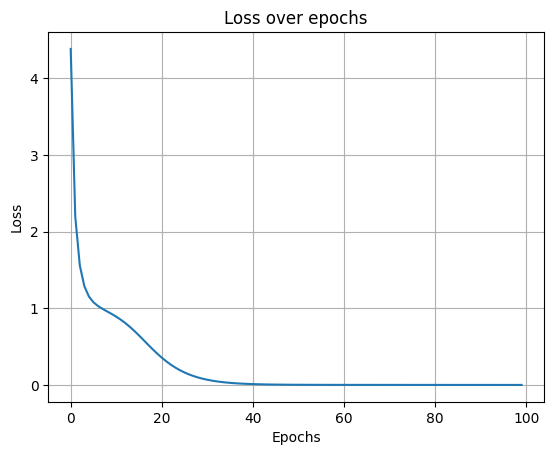

In [792]:
# Plot the loss over epochs

plt.plot(range(epochs), [item.data for item in losses])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.show()

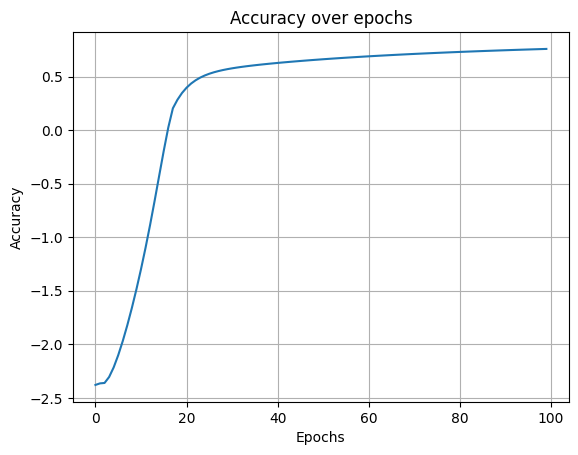

In [177]:
# Plot the accuracy over epochs
plt.plot(range(epochs), accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.grid()
plt.show()

In [171]:
# Run model training for multiple epochs with PyTorch model
epochs = 100
learning_rate = 0.05

# Initialize the parameters of the PyTorch model with the values from our model
# with torch.no_grad():
#     for param_tmlp, param_mlp in zip(tmlp.parameters(), mlp_tensor_parameters):
#         param_tmlp.copy_(param_mlp)

optimizer = optim.SGD(tmlp.parameters(), lr=learning_rate)  # Create an optimizer
tmlp.train()
loss_rmse_list = []
for epoch in range(epochs):
    optimizer.zero_grad()
    y_preds = [tmlp(torch.tensor(i)) for i in x]
    y_true = [torch.tensor([y_i.data]) for y_i in y_true]
    loss_rmse = rmse(y_true, y_preds)  # Calculate loss
    loss_rmse_list.append(loss_rmse.item())
    loss_rmse.backward()  # Perform backpropagation
    optimizer.step()  # Update parameters

Layer: Linear(in_features=3, out_features=4, bias=True), Input: (tensor([ 2.,  3., -1.]),), Output: tensor([-2.3959,  0.3937, -2.5600, -3.9107], grad_fn=<ViewBackward0>)
Layer: Tanh(), Input: (tensor([-2.3959,  0.3937, -2.5600, -3.9107], grad_fn=<ViewBackward0>),), Output: tensor([-0.9835,  0.3745, -0.9881, -0.9992], grad_fn=<TanhBackward0>)
Layer: Linear(in_features=4, out_features=4, bias=True), Input: (tensor([-0.9835,  0.3745, -0.9881, -0.9992], grad_fn=<TanhBackward0>),), Output: tensor([ 1.6032, -1.0690,  0.2200, -1.0129], grad_fn=<ViewBackward0>)
Layer: Tanh(), Input: (tensor([ 1.6032, -1.0690,  0.2200, -1.0129], grad_fn=<ViewBackward0>),), Output: tensor([ 0.9222, -0.7891,  0.2165, -0.7669], grad_fn=<TanhBackward0>)
Layer: Linear(in_features=4, out_features=1, bias=True), Input: (tensor([ 0.9222, -0.7891,  0.2165, -0.7669], grad_fn=<TanhBackward0>),), Output: tensor([0.8685], grad_fn=<ViewBackward0>)
Layer: Sequential(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (

In [172]:
# Print prediction using PyTorch model
print(f"y_preds_tmlp = {[item.item() for item in y_preds]}")
print(f"y_true = {[item.data for item in y_true]}")

y_preds_tmlp = [0.9358316659927368, -1.0214028358459473, -0.9719010591506958, 1.059489369392395]
y_true = [tensor([1.]), tensor([-1.]), tensor([-1.]), tensor([1.])]


loss_rmse_list = [1.5003691911697388, 0.9619162678718567, 0.7609615325927734, 0.655165433883667, 0.5759391188621521, 0.5016622543334961, 0.43051496148109436, 0.36708199977874756, 0.31330305337905884, 0.2682991623878479, 0.2305852323770523, 0.19882233440876007, 0.17192722856998444, 0.14904920756816864, 0.12952131032943726, 0.11281421035528183, 0.09849988669157028, 0.08622519671916962, 0.07569411396980286, 0.06665531545877457, 0.058893948793411255, 0.05222536623477936, 0.04649071767926216, 0.04155323654413223, 0.03729568049311638, 0.03361736610531807, 0.030432311818003654, 0.027667148038744926, 0.025259433314204216, 0.023156164214015007, 0.021312301978468895, 0.019689971581101418, 0.018256904557347298, 0.01698593981564045, 0.01585417240858078, 0.014842196367681026, 0.013933653943240643, 0.013114718720316887, 0.012373685836791992, 0.011700637638568878, 0.011087149381637573, 0.010526053607463837, 0.010011209174990654, 0.009537411853671074, 0.00910014659166336, 0.0086955726146698, 0.0083203

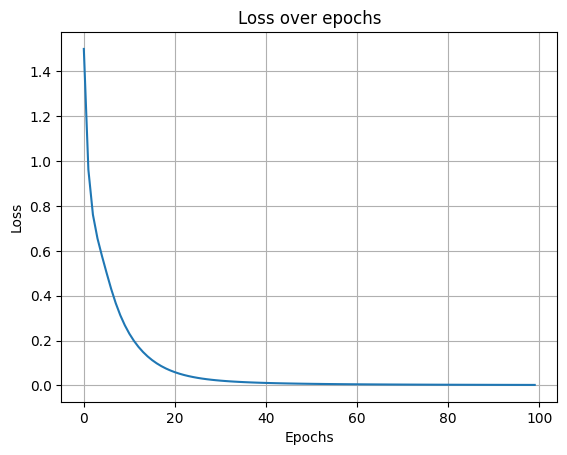

In [173]:
# Plot the loss over epochs
print(f"loss_rmse_list = {loss_rmse_list}")
plt.plot(range(epochs), loss_rmse_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.show()